## A super early proof-of-concept showing a cube navigation

In [1]:
import iris

In [2]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

First we define a generic class which contains ipywidget components which gives us sliders through our data's dimensions.

In [3]:
class CubeWidget(object):
    @classmethod
    def create(cls, *args, **kwargs):
        """
        We do a little dance to avoid having to implement a proper DOMWidget.
        That is the approach we should really be taking here...
        
        """
        widget_creator = cls(*args, **kwargs)
        widget_creator.form.widget_creator = widget_creator
        
        return widget_creator.form
    
    def __init__(self, cube):
        """
        Create the widget interface for the given cube.

        """
        form = widgets.VBox()
    
        self._shape = cube.shape
        self._ndim = len(self._shape)
        self._cube = cube
        self._current_index = None

        self.cube_summary = widgets.HTML('')
        dim_sliders = {}

        children = [self.cube_summary]

        # A maping of dimension number to slider instance.
        self._dim_sliders = {}
        self._last_index = None
        
        for dim, dim_length in list(enumerate(self._shape))[::-1]:
            coords_on_dim = cube.coords(dimensions=[dim])

            is_slider = cube.ndim - dim > 2

            if coords_on_dim:
                name = coords_on_dim[0].name()
            else:
                name = 'Axis {}'.format(dim)

            toggle = widgets.Checkbox(value=is_slider)
            label_widget = widgets.HTML(name)
            slider = widgets.IntSlider(min=0, max=dim_length - 1, visible=is_slider)

            self._dim_sliders[dim] = slider
            container = widgets.HBox(children=[label_widget, slider, toggle])

            def on_dimension_toggle_fn(slider):
                def on_dimension_toggle(name, value):
                    slider.visible = value
                return on_dimension_toggle
            
            toggle.on_trait_change(on_dimension_toggle_fn(slider), 'value')
            slider.on_trait_change(self.on_change, 'value')
            toggle.on_trait_change(self.on_change, 'value')

            children.append(container)

        form.children = children
        self.form = form
        self.finalise()

    def finalise(self):
        # Called when the initialisation is complete, and we want to trigger the first event.
        return self.on_change(None, None)
    
    def on_change(self, name, value):
        """
        An event which is triggered when any widget value is changed.

        """
        the_index = [slice(None)] * self._ndim
        for dim, slider in self._dim_sliders.items():
            if slider.visible:
                the_index[dim] = slider.value
        if self._current_index != the_index:
            self._current_index = tuple(the_index)
            sub_cube = self._cube[self._current_index]
            summary = '<b>{}</b>'.format(sub_cube.summary(True))
            scalar_info = []
            for scalar_coord in sub_cube.coords(dimensions=[]):
                units = scalar_coord.units
                if (units in ['1', 'no_unit', 'unknown'] or
                        units.is_time_reference()):
                    unit = ''
                else:
                    unit = ' {!s}'.format(units)
                
                    
                if units.is_time_reference():
                    msg = '{}'.format(units.num2date(scalar_coord.points[0]))
                else:
                    msg = '{} {}'.format(scalar_coord.points[0], unit)
                scalar_info.append('<span style="padding-left: 40px; width: 275px; display:inline-block; '
                                   'white-space:nowrap;">'
                                   '{}:</span><span>{}</span>'.format(scalar_coord.name(), msg))
            sep = '<br />'
            summary += sep + sep.join(scalar_info)
            self.cube_summary.value = summary


We can load some data to navigate through it (textually):

In [4]:
cube = iris.load_cube('./GloSea4_sample_data/ensemble_01?.pp')

In [5]:
widget = CubeWidget(cube)
widget.form

Next we will define a subclass of this navigator which adds plotting functionality.

In [6]:
%matplotlib notebook

In [7]:
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import cartopy

In [8]:
class Contourf(object):
    def __init__(self):
        self.axes = None
        self.cs = None
    
    def draw(self, cube):
        if self.axes:
            plt.sca(self.axes)
        self.cs = iplt.contourf(cube, cmap='GnBu')
        
        # Get the current axes, since Iris may change the instance.
        self.axes = plt.gca()

    def clear(self):
        if self.axes and self.axes in self.axes.figure.axes:
            self.axes.figure.axes.remove(self.axes)
        self.axes = None
        

class ContourfCoastlines(Contourf):
    def __init__(self):
        super(ContourfCoastlines, self).__init__()
        self.coastlined_axes = None
        
    def draw(self, cube):
        super(ContourfCoastlines, self).draw(cube)
        is_geoaxes = isinstance(self.axes, cartopy.mpl.geoaxes.GeoAxes)
        if is_geoaxes and self.coastlined_axes is not self.axes:
            self.axes.coastlines()
            self.coastlined_axes = self.axes
            self.axes.gridlines()

            
class Line(object):
    def __init__(self):
        self.axes = None
        self.line = None
    
    def draw(self, cube):
        if self.line and self.axes and self.line in self.axes.lines:
            self.line.set_ydata(cube.data)
            self.axes.relim()
            self.axes.autoscale_view()
        else:
            self.line, = qplt.plot(cube)
            self.axes = plt.gca()
            plt.grid(True)

    def clear(self):
        if self.axes and self.axes in self.axes.figure.axes:
            self.axes.figure.axes.remove(self.axes)
        self.axes = None

        
class PlotWidget(CubeWidget):
    def __init__(self, cube, draw_tools):
        self.fig = plt.figure()
        self.draw_tools = draw_tools
        self._axes_dims = []
        self._draw_tool = None
        super(PlotWidget, self).__init__(cube)

    def on_change(self, name, value):
        super(PlotWidget, self).on_change(name, value)

        plot_dims = [dim for dim, slider in self._dim_sliders.items()
                     if not slider.visible]
        if self._axes_dims != plot_dims:
            self._axes_dims = plot_dims
            ax = plt.subplot(1, 1, 1)
            ax.clear()
            for tool in self.draw_tools.values():
                tool.clear()
                tool.axes = ax
        
        sub_cube = self._cube[self._current_index]

        draw_tool = self.draw_tools.get(sub_cube.ndim, None)
        
        if draw_tool:
            self._draw_tool = draw_tool
            draw_tool.draw(sub_cube)
        else:
            # No draw possible for this number of dimensions.
            plt.clf()            
        plt.draw()

<IPython.core.display.Javascript object>


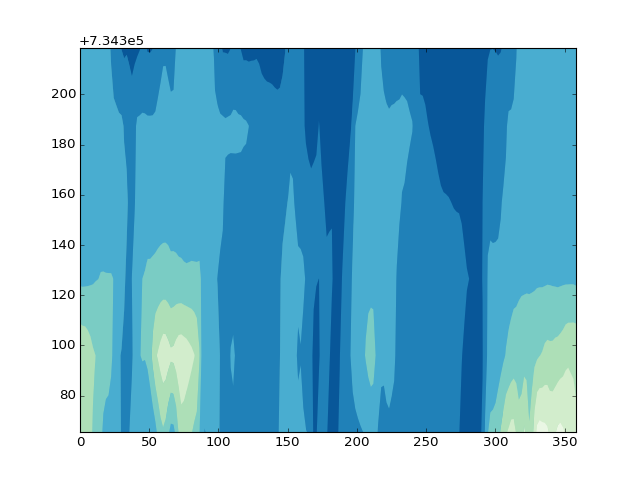

In [9]:
PlotWidget.create(cube, {1: Line(), 2: ContourfCoastlines()})